Author: Amiri Hayes \
Date Updated: 7/15/25 \
Title: ViewLLM

Starter code !

In [1]:
# package installs if necessary
!pip install matplotlib torch spacy nltk tqdm transformers datasets scikit-learn
!python3 -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
'python3' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt_tab')
import os
import csv
import json
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from typing import Optional, Tuple, Callable
import matplotlib.patches as mpatches
from matplotlib.colors import PowerNorm, ListedColormap
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import PreTrainedTokenizerBase, PreTrainedModel
print("Imports completed successfully.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amkah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Imports completed successfully.


<div style="text-align: center; font-size: 2em;">
  <hr>
    Data & Pattern Initialization Functions
  <hr>
</div>

In [ ]:
# IMPORT THE PROGRAM DATABASE:

from programs import *

In [ ]:
# GENERATE & VISUALIZE ATTENTION PATTERN SCORES FROM PROGRAMS

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = np.clip(p, 1e-12, 1.0)
    q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

def score_prediction(torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: Tuple[int, int], pattern: Callable, sentence_1: str, sentence_2: Optional[str] = None, distance="jsd", output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence_1, return_tensors="pt")

    if torch_model.config.is_encoder_decoder:
        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().numpy()

    else:
        if sentence_2 and pattern.__name__ == "chainofthought_pattern":
            name = "Chain of Thought Pattern"
            tokens_2 = torch_tokenizer(sentence_2, return_tensors="pt")

            att = torch_model(**tokens_2, output_attentions=True).attentions[layer][0, head].detach().numpy()
            pred_att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

            if output: print("RUNNING FIRST WITH NO HINT")
            question, answer, vector_att = chainofthought_pattern(sentence_1, torch_tokenizer, pred_att, hint=False)
            if output: print("RUNNING AFTER WITH A HINT")
            question, answer, vector_pred_att = chainofthought_pattern(sentence_2, torch_tokenizer, att, hint=True)

            att, pred_att = vector_att.copy(), vector_pred_att.copy()
        else:
            att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
            if pattern.__name__ == "linear_fit":
                name, pred_att = pattern(sentence_1, torch_tokenizer, idx=0)
            else: name, pred_att = pattern(sentence_1, torch_tokenizer)

    if distance == "raw":
        score = np.abs(att - pred_att).sum()
    elif distance == "jsd":
        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)

    if pattern.__name__ == "chainofthought_pattern":
        score = np.sqrt(js_divergence(att, pred_att))

    if output == "cot":
        colors = "inferno"
        fig, axes = plt.subplots(1, 2, figsize=(12, 9))
        axes[0].plot(att, color=plt.get_cmap(colors)(0.6))
        axes[0].set_title("Actual Head Attention")
        axes[1].plot(pred_att, color=plt.get_cmap(colors)(0.9))
        axes[1].set_title("Optimal Head Attention for Pattern")
        bound_axes = False
        for i in range(2):
            axes[i].set_xlabel("Token Index")
            axes[i].set_ylabel("Attention Weight")
            axes[i].grid(True)
            if bound_axes:
                axes[i].set_ylim(0, 1)
                axes[i].set_xlim(0, len(att) - 1)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        question_chart = question.replace(".", ".\n")
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nQuestion: \"{question_chart}\n\nAnswer: \"{answer}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    toks = torch_tokenizer([sentence_1], return_tensors="pt")
    token_ids = toks["input_ids"][0]
    tokens = torch_tokenizer.convert_ids_to_tokens(token_ids)

    if output == True:
        colors="Greens"
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap=colors, aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])
        im2 = axes[1].imshow(pred_att, cmap=colors, aspect='auto')
        axes[1].set_title("Optimal Head Attention for Pattern")
        fig.colorbar(im2, ax=axes[1])
        for i in range(2):
            axes[i].set_xticks(range(len(tokens)))
            axes[i].set_yticks(range(len(tokens)))
            axes[i].set_xticklabels(tokens, rotation=90)
            axes[i].set_yticklabels(tokens)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nSentence: \"{sentence_1}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "optimal":
        colors = "Oranges"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(pred_att, cmap=colors, aspect='auto')
        ax.set_axis_off()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "actual":
        colors = "Reds"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(att, cmap=colors, aspect='auto')
        ax.set_title("Example Head Attention for Pattern")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

In [25]:
# DOWNLOAD ADDITIONAL TEXT DATA (1):

file = 'data/small_text.csv'
df = pd.read_csv(file)

sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))

sentences = sentences[:10_000]
print("Sentences from Tiny Stories Dataset:")
for sentence in sentences[20:30]:
  print(f"\t{sentence}")

df_json = pd.read_json('data/generic_sentences.json')
generic_sentences = df_json[0].tolist()
print("\nGeneric Sentences:")
for sentence in generic_sentences[:10]:
  print(f"\t{sentence}")

Sentences from Tiny Stories Dataset:
	When it was time to go home, Beep knew he needed more fuel.
	He went to the fuel place and got more healthy fuel.
	Now, Beep was ready to go fast and play again the next day.
	And Beep lived happily ever after.
	One day, a little fish named Fin was swimming near the shore.
	He saw a big crab and wanted to be friends.
	"Hi, I am Fin.
	Do you want to play?"
	asked the little fish.
	The crab looked at Fin and said, "No, I don't want to play.

Generic Sentences:
	The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.
	She wondered, 'Will he ever understand the complexities of this intricate problem?'
	Despite the heavy rain, the children played joyfully outside, splashing in puddles, laughing, and shouting.
	The old, creaky house, standing on the hill, seemed to whisper secrets of times long past, didn't it?
	Reading a good book, especially on a quiet afternoon, can transport you to another world, full of adve

In [26]:
# DOWNLOAD ADDITIONAL TEXT DATA (2):

math_data = pd.read_json('data/math_problems_results.jsonl', lines=True)

filtered_results = math_data[
    (math_data['consistency'] == "False") &
    (math_data['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (math_data['evaluated_answer_hint'] != "DNF: llm did not finish")
]

answers_nohint = filtered_results['answer_nohint'].tolist()
answers_hint = filtered_results['answer_hint'].tolist()
prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"

prompts = []
for s1, s2 in zip(answers_nohint, answers_hint):
    if s1.startswith(prefix): s1 = s1[len(prefix):]
    if s2.startswith(prefix): s2 = s2[len(prefix):]

    i_suffix_s1 = s1.find("assistant")
    if i_suffix_s1 != -1: s1 = s1[:i_suffix_s1].strip()

    i_suffix_s2 = s2.find("assistant")
    if i_suffix_s2 != -1: s2 = s2[:i_suffix_s2].strip()

    if s1 and s2: prompts.append((s1, s2))

print(len(prompts), "relevant prompts loaded from math problems dataset.")

32 relevant prompts loaded from math problems dataset.


<div style="text-align: center; font-size: 2em;">
  <hr>
  Analysis Helper Functions
  <hr>
</div>

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


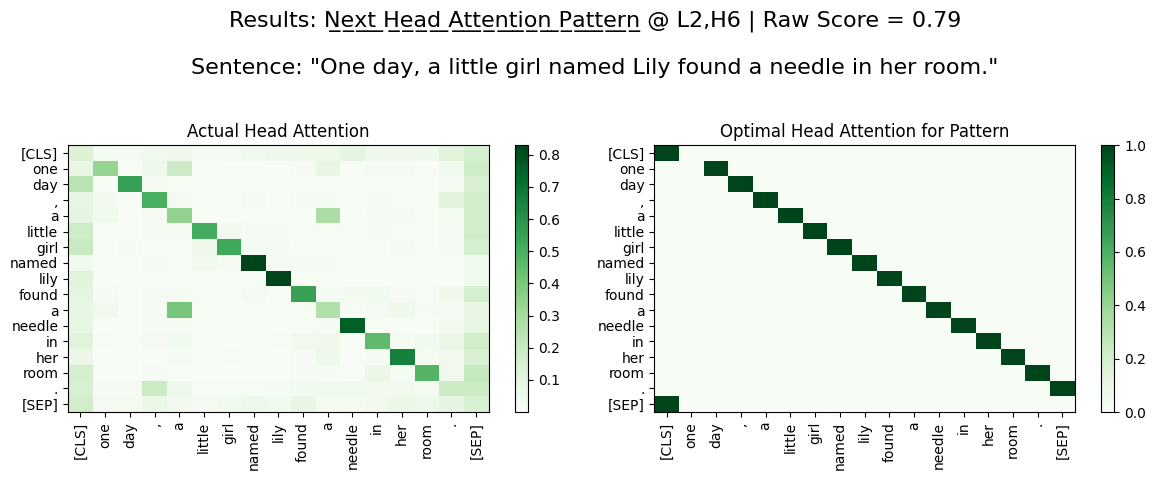

np.float64(0.7907371075535138)

In [7]:
# ANALYZE PATTERN AT LAYER AND HEAD

sentence = "The quick brown fox jumps over the lazy dog."
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
sentence = "I like apples and I like bananas. I like apples more though."

models = ["bert-base-uncased", "openai-community/gpt2", "google-t5/t5-small", "Meta-Llama-3.1-8B-Instruct"]

i = 0
name = models[i]

if i in [0,1,2]: # small models ( <400M Params )
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name, output_attentions=True)
    model.eval()

elif i == 3: # big model & cot ( 8B Params, Load from Compute Node )
    tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model.eval()

    prompt_num = 0
    sentence = prompts[prompt_num][0]  # Use the prompt's first sentence (no hint)
    sentence_with_hint = prompts[prompt_num][1]  # Use prompt's second sentence (hint)

layer, head = 2, 6
score_prediction(model, tokenizer, (layer, head), next_attention, sentences[0], distance="jsd", output=True)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (1 SENTENCE)

def visualize_full_model(sentence: str, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9, sentence_2: Optional[str] = None) -> Tuple[np.ndarray, list]:
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    model_viz = np.zeros((num_layers, num_heads))

    for i in range(num_layers):
        for j in range(num_heads):
            score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
            model_viz[i, j] = score
    print(f"Best Score: {min(map(min, model_viz)):.2f}")

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=model_viz.min(), vmax=model_viz.max())
    plt.imshow(model_viz, cmap='Greens_r', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    top_three = list(zip(*np.unravel_index(np.argsort(model_viz, axis=None)[:3], model_viz.shape)))
    for tuple_val in top_three:
        layer, head = tuple_val
        score = model_viz[layer, head]
        print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return model_viz, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
pattern_name = "Repeated Attention Pattern"
underlined_name_unicode = "".join([char + '\u0332' for char in pattern_name])
visualize_full_model(sentence, model, tokenizer, repeated_attention, title=f"Top Heads: {underlined_name_unicode} | {model_name}\nSentence: \"{sentence}\"\n", bias_towards_best=0.7)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (MULTIPLE SENTENCES)

def visualize_full_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9) -> Tuple[np.ndarray, list]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    header = ["Layer", "Head", "Score"]
    csv_file_name = "scores.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
    
        average_score = np.zeros((num_layers, num_heads))
        for sentence in sentences:
            sentence_1 = sentence[0]  # first sentence (no hint)
            sentence_2 = sentence[1]  # second sentence (hint)
            model_score = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    score = score_prediction(model, tokenizer, (i, j), chainofthought_pattern, sentence_1, sentence_2, distance="jsd", output=False)
                    writer.writerow([i, j, f"{score:.2f}"])
                    print(f"Layer {i}, Head {j} - Score: {score:.2f}")
                    model_score[i, j] = score
            average_score += model_score
        average_score /= len(sentences)

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=average_score.min(), vmax=average_score.max())
    plt.imshow(average_score, cmap='Reds', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    if pattern.__name__ == "chainofthought_pattern": 
        top_three = list(zip(*np.unravel_index(np.argsort(average_score.ravel())[::-1][:3], average_score.shape))) # highest scores
    else:
        top_three = list(zip(*np.unravel_index(np.argsort(average_score, axis=None)[3:], average_score.shape))) # lowest scores
        top_three = np.sort(average_score)

    for tuple_val in top_three:
            layer, head = tuple_val
            score = average_score[layer, head]
            print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return average_score, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentences_zipped = list(zip(answers_nohint[:5], answers_hint[:5]))
visualize_full_model(sentences_zipped, model, tokenizer, chainofthought_pattern, title="Top Heads: Chain-of_Thought Evaluation [AVERAGE]\n"+model_name, bias_towards_best=0.7)

In [ ]:
# FILTER SENTENCES TO TARGET SPECIFIC PATTERNS

def filterer(sentences: list[str], length_matters: bool=False, punctuation_matters: bool=False, duplicates: bool=False) -> list[str]:
    filtered_sentences = []
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    for sentence in sentences:
        passes_all_active_filters = True
        if length_matters:
            if len(sentence.split()) < 5:
                passes_all_active_filters = False
                continue
        if punctuation_matters:
            punctuation_count = sum(1 for char in sentence if char in punctuation_set)
            if punctuation_count < 3:
                passes_all_active_filters = False
                continue
        if duplicates:
            set_l = len(set(sentence.split()))
            sent_1 = len(sentence.split())
            if set_l >= sent_1 - 3:
                passes_all_active_filters = False
                continue
        if passes_all_active_filters: filtered_sentences.append(sentence)
    return filtered_sentences

filtered_sentences = filterer(generic_sentences, length_matters = True)

In [ ]:
# ANALYZE HEAD PATTERN ON SELECTED SENTENCES

def visualize_highest_head(sentences: list[str], top_n:  int, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: tuple[int, int], pattern: Callable):
    layer, head = head_loc
    scores = []

    for sentence in tqdm(sentences):
        score = score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
        scores.append(score)

    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key= lambda x: x[1])
    top_scores = sorted_scores[:top_n]

    for idx, score in top_scores:
        print(f"Sentence #{idx} Score: {score}")
        sentence = sentences[idx]
        score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, output=True)
    return 0

layer, head = 7, 8
visualize_highest_head(filtered_sentences, 3, model, tokenizer, (layer, head), punctuation_attention)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS

def classify_whole_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, patterns: list[Callable]) -> dict[Tuple[int, int], Tuple[str, float]]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads
    activations = {}  # key: (i, j), value: (pattern_name, score)
    header = ["i", "j", "Pattern", "Score"]
    
    csv_file_name = "data/best_fit.csv"
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
        for pattern in patterns:
            print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
            avg_score = []
            for idx, sentence in enumerate(sentences):
                if idx % 20 == 0: print(f"\tProcessing sentence {idx}/{len(sentences)}")
                for i in range(num_layers):
                    for j in range(num_heads):
                        score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                        avg_score.append(score)

                        
                avg_score = np.mean(avg_score)
                print(i, j, avg_score)
            if avg_score > 0.5: continue
            key = (i, j)

            if key not in activations or avg_score < activations[key][1]:
                activations[key] = (pattern.__name__, avg_score)
            writer.writerow([i, j, pattern.__name__, avg_score])

    return activations

patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
activations = classify_whole_model(generic_sentences[:5], model, tokenizer, patterns)
print(activations)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS (CONTINUED)

torch_model = model
torch_tokenizer = tokenizer

num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads
activations = {}  # key: (i, j), value: (pattern_name, score)

patterns = [next_attention, previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, dependencies, pos_alignment]

short = sentences[:3]
csv_file_name = "data/best_fit_2.csv"
with open(csv_file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    for pattern in patterns:
        print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
        avg_score = []
        for idx, sentence in enumerate(short):
            print(f"\tProcessing sentence {idx}/{len(short)}")
            for i in range(num_layers):
                for j in range(num_heads):
                    if i != 3 or j != 9: continue
                    score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                    if score < 0.55:
                        avg_score.append((idx, pattern.__name__, i, j, score))
        
        score_dict = {}
        for idx, pattern_name, i, j, score in avg_score:
            score_dict.setdefault((i, j), []).append((pattern_name, score))
        for (i, j), values in score_dict.items():
            scores = [score for _, score in values]
            avg_score_val = sum(scores) / len(scores)
            pattern_name = values[0][0]
            activations[(i, j)] = (pattern_name, avg_score_val)
            print(f"Layer {i}, Head {j} - Score: {avg_score_val:.2f}")
            writer.writerow([i, j, pattern.__name__, avg_score_val])


Currently Analyzing pattern: next_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: previous_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: same_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: punctuation_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: repeated_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: pos_alignment
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sent

In [ ]:
# ANALYZE EFFECT OF LINEAR WEIGHTS ON ATTENTION ACTIVATION ACCURACY

def generate_dataset(patterns: list[Callable], model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, sentences: list[str], layer_head: tuple[int, int]):
    layer, head = layer_head
    X_data, y_data = [], []
    print("Generating dataset for Layer", layer, ", Head", head)

    for sentence in tqdm(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]
        X_i_list = []
        for pattern in patterns:
            _, X_i = pattern(sentence, tokenizer)
            X_i = torch.tensor(X_i, dtype=torch.float32)
            X_i_list.append(X_i)
        X_data.append(X_i_list)
        y_data.append(attn)

    torch.save({'X': X_data, 'y': y_data}, "data/attention_dataset.pt")
    print("Dataset generated and saved to 'data/attention_dataset.pt'.")

def train_linearregression() -> pd.DataFrame:
    data = torch.load("data/attention_dataset.pt")
    X, y = data['X'], data['y']
    X, y = data['X'], data['y']
    output = []

    for i, (xb, yb) in enumerate(zip(X, y)):
        xb = torch.stack(xb)
        X_flat = (xb.reshape(len(xb), -1).T).numpy()
        y_flat = yb.flatten().numpy()
        reg = LinearRegression().fit(X_flat, y_flat)
        if i % 100 == 0: print(f"Sentence #{i} - Coeffs: {[float(f"{coef:.2f}") for coef in reg.coef_]}, Intercept: {reg.intercept_:.2f}")
        output.append([reg.coef_.tolist(), float(reg.intercept_)])

    output = pd.DataFrame(output, columns=["Coefficients", "Intercept"]).to_csv("data/linear_regression_results.csv", index=False)
    return output

head_loc = (3, 9)
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
generate_dataset(patterns, model, tokenizer, sentences, head_loc)
output = train_linearregression()

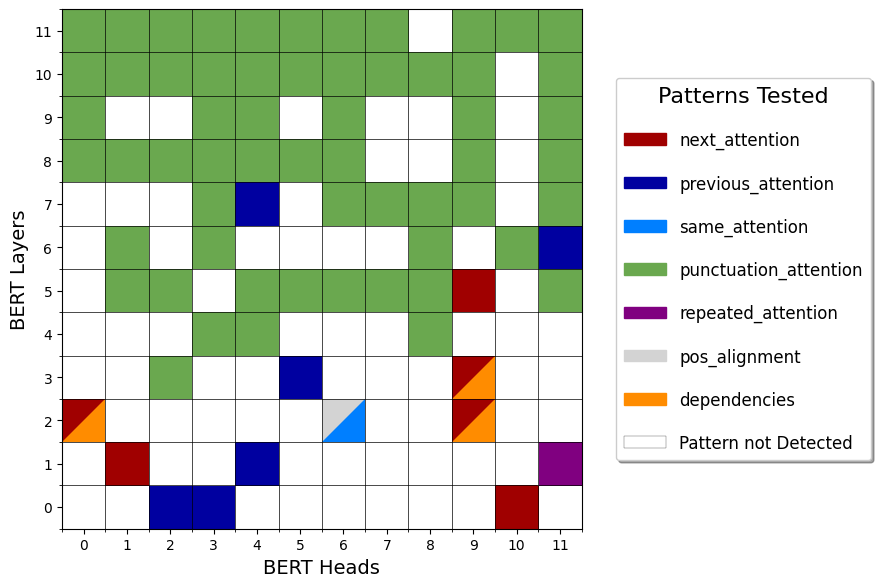

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZE BEST FIT PATTERNS ACROSS LAYERS AND HEADS

df = pd.read_csv('data/best_fit.csv')
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
mat = np.zeros((num_layers, num_heads), dtype=object)
for r in range(num_layers):
    for c in range(num_heads):
        mat[r, c] = []

for (i, j), group in df.groupby(['i', 'j']):
    sorted_group = group.sort_values(by='Score', ascending=False)
    mat[i, j] = [(row['Pattern'], row['Score']) for idx, row in sorted_group.iterrows()]

unique_patterns = df['Pattern'].unique()

dark_orange = '#FF8C00'
dark_blue = '#0000A0'
azure = '#007FFF'
medium_green = '#6aa84f'
gray = '#D3D3D3'
dark_red = '#A00000'
purple = '#800080'

hex_colors = [dark_red, dark_blue, azure, medium_green, purple, gray, dark_orange]
cmap_patterns = ListedColormap(hex_colors, name='my_cmap')

pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}
white_color = (1, 1, 1, 1)
plotting_matrix_rgb = np.zeros((num_layers, num_heads, 3))

for r in range(num_layers):
    for c in range(num_heads):
        cell_data = mat[r, c]
        
        if not cell_data:
            plotting_matrix_rgb[r, c] = white_color[:3]
        elif len(cell_data) == 1: 
            pattern_name = cell_data[0][0]
            plotting_matrix_rgb[r, c] = pattern_colors[pattern_name][:3]
        else:
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            color_1 = pattern_colors[top_pattern_1][:3]
            color_2 = pattern_colors[top_pattern_2][:3]
            plotting_matrix_rgb[r, c] = color_1 

custom_draw_mask = np.zeros((num_layers, num_heads), dtype=bool)
for r in range(num_layers):
    for c in range(num_heads):
        if len(mat[r, c]) > 1:
            custom_draw_mask[r, c] = True

fig, ax = plt.subplots(figsize=(9, 18))
img = ax.imshow(plotting_matrix_rgb, origin='lower', extent=[-0.5, num_heads - 0.5, -0.5, num_layers - 0.5])

for r in range(num_layers):
    for c in range(num_heads):
        if custom_draw_mask[r, c]:
            cell_data = mat[r, c]
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            
            color_1 = pattern_colors[top_pattern_1]
            color_2 = pattern_colors[top_pattern_2]
            triangle1 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c + 0.5, r - 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_1, edgecolor='none'
            )
            ax.add_patch(triangle1)
            triangle2 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c - 0.5, r + 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_2, edgecolor='none'
            )
            ax.add_patch(triangle2)

ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticks(np.arange(-0.5, num_heads, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_layers, 1), minor=True)
ax.set_xlabel('BERT Heads', fontsize=14)
ax.set_ylabel('BERT Layers', fontsize=14)
# ax.set_title('Pattern Distribution Across Layers and Heads')
ax.set_aspect('equal')
# ax.grid(color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

legend_handles = []
for pattern, color in pattern_colors.items():
    patch = mpatches.Patch(color=color, label=pattern)
    legend_handles.append(patch)

white_patch = mpatches.Patch(facecolor=white_color, label='Pattern not Detected', edgecolor='black', linewidth=0.2)
legend_handles.append(white_patch)
 
ax.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True, 
    title="Patterns Tested",
    title_fontsize=16,
    fontsize='large', # Make legend text bigger. Can use 'medium', 'x-large', 'xx-large' or a numerical value (e.g., 12)
    labelspacing=1.5, # Adjust vertical spacing between legend entries (default is 0.5)
    handlelength=2.5, # Adjust length of the color patch/line in the legend
    handletextpad=0.8, # Adjust space between the handle (color patch) and the text label
    borderpad=0.5 # Adjust padding between the legend content and its border
    
) 
plt.tight_layout()
plt.show()

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the legend
plt.show()

In [ ]:
# CONDUCT MODEL LEVEL ANALYSIS / GET SUMMARY SCORE FOR WHOLE MODEL

def classify_model(method, sentences, torch_model, torch_tokenizer):
    if method == "linear_fit":
        patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
    elif method == "best_fit":
        saved_file = pd.read_csv('data/best_fit_2.csv')

    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    all_scores = []
    final_scores = []
        
    for idx, sentence in enumerate(sentences):
        scores = np.zeros((num_layers, num_heads))
        for i in range(num_layers):
            for j in range(num_heads):
                layer, head = i, j
                inputs = torch_tokenizer(sentence, return_tensors="pt")
                len_seq = len(torch_tokenizer([sentence], return_tensors="pt").input_ids[0])

                X = []
                y =  torch_model(**inputs, output_attentions=True).attentions[layer][0, head].detach().numpy()

                if method == "linear_fit":
                    for pattern in patterns:
                        X.append(pattern(sentence, torch_tokenizer)[1].flatten())
                    X_n = np.array(X).T
                    y = y.flatten()

                    reg = LinearRegression().fit(X_n, y)
                    side_length = int(np.sqrt(len(y)))
                    y = y.reshape((side_length, side_length))

                    pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                    pred_att = pred_att.reshape((side_length, side_length))
                
                elif method == "best_fit":
                    matching_rows = saved_file[(saved_file['i'] == i) & (saved_file['j'] == j)]
                    if not matching_rows.empty:
                        best_pattern = matching_rows.loc[matching_rows['Score'].idxmax(), 'Pattern']
                        func = globals()[best_pattern]
                        _, pred_att = func(sentence, tokenizer)
                    else:
                        out = np.random.rand(len_seq, len_seq)
                        pred_att =  out / out.sum(axis=1, keepdims=True)

                elif method == "random_baseline":
                    # out = np.random.rand(len_seq, len_seq)
                    # pred_att =  out / out.sum(axis=1, keepdims=True)

                    pred_att = np.zeros((len_seq, len_seq))
                    pred_att[:, -1] = 1.0

                jensonshannon_distances = []
                for row_att, row_out in zip(y, pred_att):
                    jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                score = np.mean(jensonshannon_distances)
                scores[layer, head] = score
                
        all_scores.append(scores)
        final_scores.append(np.sum(scores))
        print(f"Processed sentence #{idx}/{len(sentences)}: Score: {np.sum(scores):.2f}\n\t->'{sentence}'")

    print(f"Final Score: {sum(final_scores) / len(final_scores)}")
    return all_scores, final_scores

classify_model("random_baseline", sentences[:3], model, tokenizer)

<div style="text-align: center; font-size: 2em;">
  <hr>
    Program Automation Efforts
  <hr>
</div>

In [ ]:
# AUTOMATICALLY GENERATE PATTERNS FOR A HEAD

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    name = model.config.architectures[0]
    data = {
        "layer": layer,
        "head": head,
        "model": model_name,
        "examples": []
    }
    def scrape_head(att, tokens, ignore_special=True, top_k_ratio=0.1):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append({
                f"from_token_{i}": tokens[i],
                f"to_token_{j}": tokens[j],
                "weight": float(score)
            })
        return top_activations
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=top_k_ratio)
        item = {
            "sentence": sentence,
            "attention": top_activations
        }
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences[0])} sentences, generate three
    hypothesises about the linguistic role the following head is responsible for based on patterns
    in the activations. These patterns can be simple or complex. Here are some examples: {data} Then, choose the most fitting hypothesis for the head responsibility using a few examples from the data.
    Finally, using the linguistic hypothesis you determine, write a python function which takes in a sentence and tokenizer as parameters and
    outputs the name of the pattern you hypothesize along with a 'predicted_matrix' (size: token_len * token_len),
    which is the rule-encoded matrix that mirroring attention patterns you'd predict for any given sentence for
    Layer {layer}, Head {head}. Feel free to use the capacbilities of proved libraries like spacey and nltk for describing linguistic concepts. Feel free to encode complex functions. Make sure you generalize your hypothesis pattern to any sentence. As examples:,
    Layer 3, Head 9 has been found to be responsible for dependency parsing. It's predicted pseudocode would look like:
    def dependencies(sentence, tokenizer):
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = sentence.split()
    # use spacey nlp to split word into doc dependency tree
    # loop through each node in tree and assign directional attention
    # to the matrix 'out' by adding one when there is an outgoing edge.
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention
    # Normalize out matrix by row (results in uniform attention) and return out
    return 'Dependency Parsing Pattern', out
    Here is another pseudocode example for one method to implement part-of-speech:
    def pos_alignment(sentence, tokenizer):
    # assign toks, input_ids, word_ids, len_seq, out, doc
    # use spacey to get pos_tags for tokens in docs [token.pos_ for token in doc]
    # for token in pos_tags:
    # loop through pos_tags and increment out[i,j] when pos_tags match
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention
    # Normalize out matrix by row (results in uniform attention) and return out
    # return 'Part of Speech Implementation 1', out
    """
    return ' '.join(prompt.strip().split())

pd = pd.read_csv('data/small_text.csv')
model_name = models[0]
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
generate_prompt(generic_sentences, model, tokenizer, (7, 1), 0.05)

In [ ]:
def hypothesize_function(prompt):
    llm_idea = "preprocessing here"
    return llm_idea

In [ ]:
def parse_idea(llm_idea):
    fn_name = "get llm idea name"
    llm_function = "get llm function"
    return fn_name, llm_function

In [ ]:
def automation_pipeline(model, tokenizer, head_loc, sentences, evaluate=False):
    layer, head = head_loc
    prompt = generate_prompt(sentences, model, tokenizer, head_loc, 0.05)
    print("Step 1... Generated Prompt")
    llm_idea = hypothesize_function(prompt)
    print("Step 2... Coded Function")
    idea_name, fn = parse_idea(llm_idea)
    print("Step 3... Validating Function")

    if evaluate:
        visualize_highest_head(filtered_sentences, 8, model, tokenizer, (layer, head), fn)
        visualize_full_model(sentences[0:5], model, tokenizer, fn, title=f"Top Heads: {idea_name} [AVERAGE]\n"+model_name, bias_towards_best=0.7)
    return idea_name, fn

<div style="text-align: center; font-size: 2em;">
  <hr>
    Hypothesis Structure Experiments
  <hr>
</div>

In [33]:
import networkx as nx
from programs import *

programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies, last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment]
sentence_data = sentences[:25]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
S = np.zeros((x, x))
for i in range(x):
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if i != j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                h2, activations_two = program_two(sentence, tokenizer)
                similarities.append(program_similarity(activations_one, activations_two))
            
            S[i, j] = np.mean(similarities)

calculating hypothesis similarities [0]: next_attention
calculating hypothesis similarities [1]: previous_attention
calculating hypothesis similarities [2]: same_attention
calculating hypothesis similarities [3]: punctuation_attention
calculating hypothesis similarities [4]: dependencies


C:\Users\amkah\AppData\Local\Temp\ipykernel_17224\96696363.py:19: RuntimeWarning: invalid value encountered in sqrt
  jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))


calculating hypothesis similarities [5]: last_token_attention
calculating hypothesis similarities [6]: uniform_attention
calculating hypothesis similarities [7]: cls_attention
calculating hypothesis similarities [8]: eos_attention
calculating hypothesis similarities [9]: pos_alignment


In [34]:
S

array([[0.        , 0.72248264, 0.72248264, 0.7347226 , 0.51406976,
        0.78389433, 0.75489314, 0.72248264, 0.77751862, 0.7590144 ],
       [0.72248264, 0.        , 0.72248264, 0.8322484 , 0.58349394,
        0.83255461, 0.75489314, 0.66744665, 0.83255461, 0.7590144 ],
       [0.72248264, 0.72248264, 0.        , 0.8322484 , 0.72162638,
        0.80822447, 0.75489314, 0.72248264, 0.83255461, 0.35187654],
       [0.7347226 , 0.8322484 , 0.8322484 , 0.        , 0.8112586 ,
        0.20738833, 0.6822155 , 0.8322484 , 0.4474114 , 0.75834177],
       [0.51406976, 0.58349394, 0.72162638, 0.8112586 , 0.        ,
        0.8223732 ,        nan, 0.72162638, 0.82875607, 0.74016625],
       [0.78389433, 0.83255461, 0.80822447, 0.20738833, 0.8223732 ,
        0.        , 0.700068  , 0.83255461, 0.4645014 , 0.78045192],
       [0.75489314, 0.75489314, 0.75489314, 0.6822155 ,        nan,
        0.700068  , 0.        , 0.75489314, 0.75489314, 0.70565105],
       [0.72248264, 0.66744665, 0.7224826

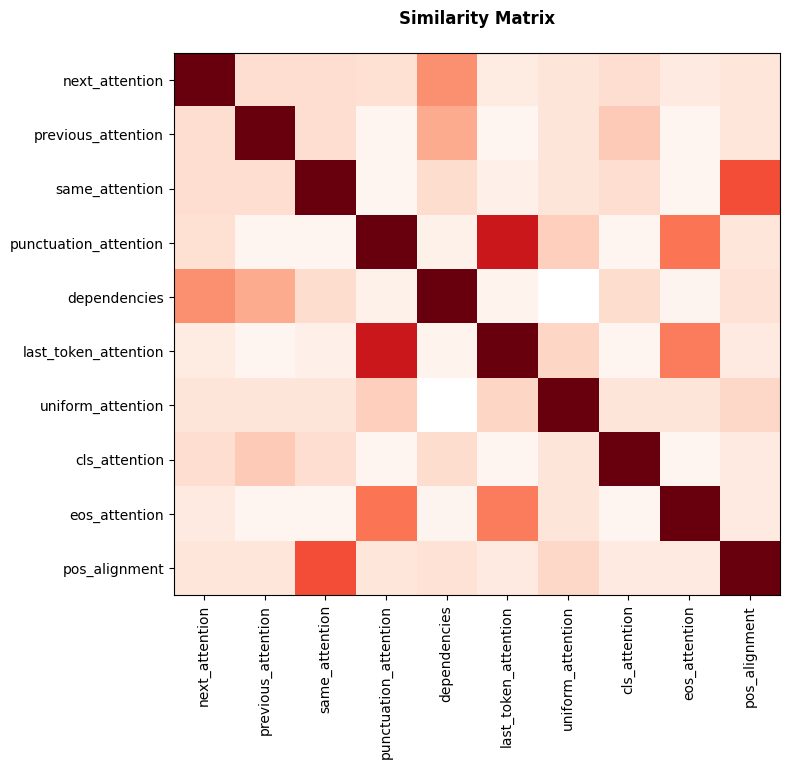

In [50]:
colors = "Reds_r"
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im2 = ax.imshow(S, cmap=colors, aspect='auto')
# ax.set_axis_off()
ax.set_xticks(range(len(programs)))
ax.set_yticks(range(len(programs)))
ax.set_xticklabels([p.__name__ for p in programs], rotation=90)
ax.set_yticklabels([p.__name__ for p in programs])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Similarity Matrix\n", weight='bold')
plt.show()

In [52]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.6)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['next_attention', 'dependencies', 'previous_attention']
Group 2: ['same_attention', 'pos_alignment']
Group 3: ['punctuation_attention', 'last_token_attention', 'eos_attention']
Group 4: ['uniform_attention']
Group 5: ['cls_attention']
